# LGBMRegressor and fewer features

### Table of Contents
1. loading data
2. Data Preprocessing
    - 2.1 Handling Missing Data
    - 2.2 Data Validation
    - 2.3 OneHotEncoding for Multi-Select Features
    - 2.4 ordering values of ordinal variables
3. Embedded Methods: Feature Importance-base...
    - 3.1 Initial Model Training with All Features
    - 3.2 Visualizing Feature Importances
    - 3.3 Embedded Feature Selection 
4. Exhaustive Feature Selection
    - 4.1 Initial Subset Evaluation
    - 4.2 Refined Subset Search
5. Final Model Development
    - 5.1 Training with Selected Features
    - 5.2 Model Saving in pkl-format

# 1. Importing the dataset and libraries

In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split 
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import itertools
import pickle


df=pd.read_csv('Carbon_Emission.csv',sep=";")

#data can be found at https://www.kaggle.com/datasets/dumanmesut/individual-carbon-footprint-calculation/data


# change display settings to show all columns
pd.set_option('display.max_columns', None)

# Setze die maximale Breite einer Spalte auf None, um keine Begrenzung zu haben
pd.set_option('display.max_colwidth', None)


#rename
# rename columns: replace spaces with underscores
df.columns = df.columns.str.replace(' ', '_')
# Rename 'public' to 'public transport' and the car-typs - to make the information easier to understand
df['Vehicle_Type'] = df['Vehicle_Type'].replace({'public': 'public transport', 'petrol': 'car (type: petrol)','diesel': 'car (type: diesel)',
                                                'hybrid': 'car (type: hybrid)','lpg': 'car (type: lpg)','electric': 'car (type: electric)'})
df['Transport'] = df['Transport'].replace({'public': 'public transport', 'private': 'car'})


df.head()

,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public transport,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,car,car (type: petrol),never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,car,car (type: diesel),often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


# 2. Data Preprocessing

## 2.1 Handling Missing Data

**I want to combined information of the variables "Transport" and "Vehicle Type" into a new one column "Transport_Vehicle_Type" to get rid of the NaN-entries in "Vehicle Type"**

In [162]:
##create new column "Transport Vehicle Type" 
df["Transport_Vehicle_Type"]=df["Vehicle_Type"] #create a new column
df.loc[df["Transport_Vehicle_Type"].isna(), "Transport_Vehicle_Type"] = df["Transport"] # Werte aus 'Transport' übernehmen, wenn 'Vehicle Type' NaN ist


##veranschaulichen der neuen Spalten und ihrer Werte
df[["Transport","Vehicle_Type","Transport_Vehicle_Type"]].head()

,Transport,Vehicle_Type,Transport_Vehicle_Type
0,public transport,NaN,public transport
1,walk/bicycle,NaN,walk/bicycle
2,car,car (type: petrol),car (type: petrol)
3,walk/bicycle,NaN,walk/bicycle
4,car,car (type: diesel),car (type: diesel)


In [163]:
#delete columns that we don't need any more because all the information is in "Transport_Vehicle_Type"
df=df.drop(["Transport","Vehicle_Type"],axis=1)
df.head(3)

,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission,Transport_Vehicle_Type
0,overweight,female,pescatarian,daily,coal,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238,public transport
1,obese,female,vegetarian,less frequently,natural gas,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892,walk/bicycle
2,overweight,male,omnivore,more frequently,wood,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595,car (type: petrol)


## 2.2 Data Validation

in simulating the data set the creators seemed to have linked the use of a cooking with grill and the use of an airfryer. Consequently, we excluded the airfryer from the variables, as it did not contain any additional information. We found this out by doing a correlation matrix for the dummy-variables.

In [164]:

# Remove "Airfryer" from the 'Cooking_With'-variable
df['Cooking_With'] = df['Cooking_With'].str.replace(", 'Airfryer'", "") 

# Check if the removal was successful
unique_values_cooking_With= set([item for sublist in df['Cooking_With'].unique() for item in eval(sublist)]) # Create a set of all unique "Cooking_With" options
print(unique_values_cooking_With)   

{'Grill', 'Oven', 'Microwave', 'Stove'}


## 2.3 OneHotEncoding for Multi-Select Features ("Recycling" and "Cooking_With")

In [165]:

# Function to create dummy variables for a given column that has multi-select features
def create_dummy_variables(df, column_name):

    # Extract unique values from the column
    unique_values = {item for sublist in df[column_name].unique() for item in eval(sublist)}
    
    # Create dummy variables for each unique value
    for item in unique_values:
        df[f'{column_name}_{item}'] = df[column_name].apply(lambda x: 1 if item in x else 0)

    # Drop the original column after creating dummy variables
    df = df.drop([column_name], axis=1)

    return df


# Generate dummy variables for Recycling and Cooking_With columns
df = create_dummy_variables(df, 'Recycling')
df = create_dummy_variables(df, 'Cooking_With')


#############
#Person 282 cooks with "nothing" deshalb can bei one-hot-encoding nicht eine Spalte gelöscht werden, person 283 who doesn't recycle deshalb can bei one-hot-encoding nicht eine Spalte gelöscht werden
#view the dummy variables
df.loc[282:283, :]

,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,CarbonEmission,Transport_Vehicle_Type,Recycling_Plastic,Recycling_Glass,Recycling_Metal,Recycling_Paper,Cooking_With_Grill,Cooking_With_Oven,Cooking_With_Microwave,Cooking_With_Stove
282,underweight,male,vegan,daily,coal,often,129,rarely,1351,medium,6,5,13,7,No,1484,public transport,1,0,1,1,0,0,0,0
283,overweight,female,vegetarian,less frequently,natural gas,often,65,very frequently,436,small,2,9,46,23,Yes,2955,public transport,0,0,0,0,1,0,0,1


## 2.4 ordering values of ordinal variables

In [166]:
#ordering values of ordinal variables

# dictonary of ordinal categorical variables. perpose of this dictonary: values of categorical variables can be ordered
dict_variables_ordinal_categorical = {
    'Body_Type': ['underweight', 'normal', 'overweight', 'obese'],
    'Diet': ['vegan','vegetarian','pescatarian','omnivore'],
    'How_Often_Shower': ['less frequently','daily', 'twice a day','more frequently'],
    'Social_Activity': ['never', 'sometimes','often'],
    'Frequency_of_Traveling_by_Air': ['never', 'rarely', 'frequently', 'very frequently'],
    'Waste_Bag_Size': ['small','medium', 'large', 'extra large'],
    'Energy_efficiency': ['Yes', 'Sometimes', 'No']
} 
#Kategorien definieren: Verwende pd.Categorical, um die values von ordinal categorical variables in der gewünschten Reihenfolge zu definieren. Die Option ordered=True stellt sicher, dass die Kategorien als geordnet behandelt werden.
for column, col_ordering in dict_variables_ordinal_categorical.items():
    df[column] = pd.Categorical(df[column], categories=col_ordering, ordered=True)   #chatGPT did the programming for me

#example
df['Waste_Bag_Size'].unique()

['large', 'extra large', 'small', 'medium']
Categories (4, object): ['small' < 'medium' < 'large' < 'extra large']

## 2.5 Converting nominal variables to Data Types Categorical

In [167]:
object_dtypes = df.select_dtypes(include='object').columns.tolist()  # = ['Sex', 'Heating_Energy_Source', 'Transport_Vehicle_Type']

# Convert categorical columns to category dtype
df[object_dtypes] = df[object_dtypes].astype('category')    #chatGPT wrote that for me

#test if changes were sucessful
df.dtypes

Body_Type                        category
Sex                              category
Diet                             category
How_Often_Shower                 category
Heating_Energy_Source            category
Social_Activity                  category
Monthly_Grocery_Bill                int64
Frequency_of_Traveling_by_Air    category
Vehicle_Monthly_Distance_Km         int64
Waste_Bag_Size                   category
Waste_Bag_Weekly_Count              int64
How_Long_TV_PC_Daily_Hour           int64
How_Many_New_Clothes_Monthly        int64
How_Long_Internet_Daily_Hour        int64
Energy_efficiency                category
CarbonEmission                      int64
Transport_Vehicle_Type           category
Recycling_Plastic                   int64
Recycling_Glass                     int64
Recycling_Metal                     int64
Recycling_Paper                     int64
Cooking_With_Grill                  int64
Cooking_With_Oven                   int64
Cooking_With_Microwave            

---
# 3. Embedded Methods: Feature Importance-based Selection
- we trained the LightGBM model and visualized feature importances to illustrate the impact of each feature on the prediction, helping us understand which variables are most influential.
- analyzed which 11 features contributed most significantly to predicting carbon emissions.

### 3.1 Initial Model Training with All Features 
To assess feature importance, wwe trained the LightGBM model and visualized feature importances to illustrate the impact of each feature on the prediction, helping us understand which variables are most influential.

with R-squared (from train-set): 0.992 and R-squared (from test-set): 0.979

In [168]:
X = df.drop("CarbonEmission",axis=1)

y = df["CarbonEmission"]

#no split because we don't care about R-squared, we care about the most important features and those change after every run due to train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, #random_state=42#)
    
    # Specify the categorical features by column names
categorical_features = X.select_dtypes(include='category').columns.tolist()    #chatGPT wrote that for me

model = LGBMRegressor(verbose=-1)  # verbose=-1: This suppresses almost all LightGBM log messages during the training process.
model.fit(X, y, categorical_feature=categorical_features)

#evaluate
y_pred = model.predict(X)
scores = r2_score(y, y_pred)
print(f" R-squared: {scores:.3f}")

 R-squared: 0.991


### 3.2 Visualizing Feature Importances

Feature Importances:
                          feature  importance
12   How_Many_New_Clothes_Monthly         361
8     Vehicle_Monthly_Distance_Km         360
10         Waste_Bag_Weekly_Count         285
6            Monthly_Grocery_Bill         205
15         Transport_Vehicle_Type         185
0                       Body_Type         176
7   Frequency_of_Traveling_by_Air         175
1                             Sex         168
13   How_Long_Internet_Daily_Hour         162
9                  Waste_Bag_Size         159
4           Heating_Energy_Source         123
5                 Social_Activity         109
2                            Diet          94
19                Recycling_Paper          74
18                Recycling_Metal          59
14              Energy_efficiency          57
17                Recycling_Glass          57
16              Recycling_Plastic          42
11      How_Long_TV_PC_Daily_Hour          41
21              Cooking_With_Oven          39
3            

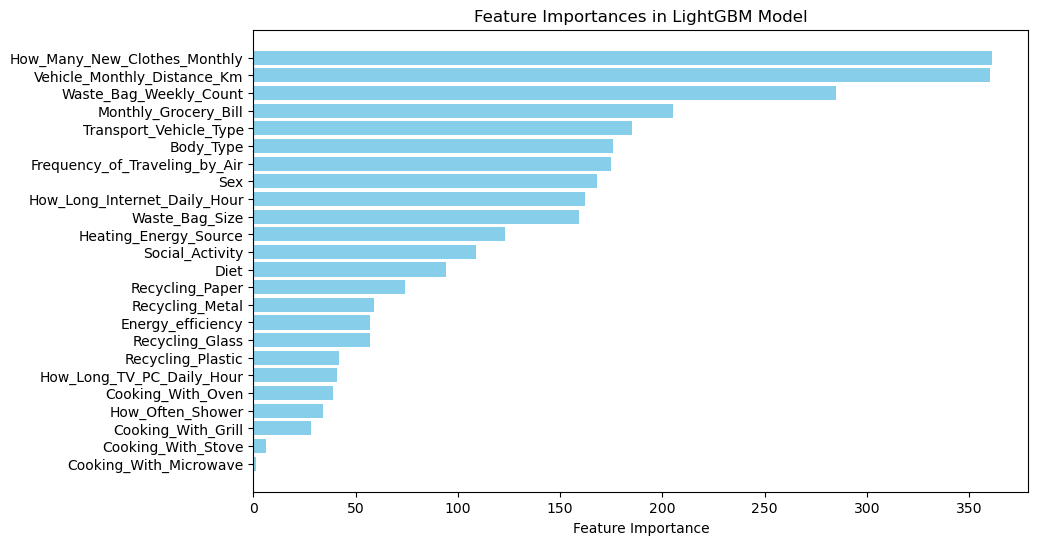

In [169]:
#chatGPT wrote this code-piece

 
# Creating a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Displaying feature importances
print("Feature Importances:")
print(feature_importance_df)

####################################

#plot-Formatierungen
plt.figure(figsize=(10, 6))

# barh: horizontal bar. Eingabewerte: Spaltennamen & feature_importances
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='skyblue')

#plot-Formatierungen
plt.xlabel('Feature Importance')
plt.title('Feature Importances in LightGBM Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

---
### 3.3 Embedded Feature Selection

if we take the top 6 features:
* "Vehicle_Monthly_Distance_Km", "How_Many_New_Clothes_Monthly", "Waste_Bag_Weekly_Count", "Monthly_Grocery_Bill", "Body_Type", "Transport_Vehicle_Type"

we get:
- R-squared (from train-set): 0.729
- R-squared (from test-set): 0.617

In [170]:
columns_combination = ["Vehicle_Monthly_Distance_Km", "How_Many_New_Clothes_Monthly", "Waste_Bag_Weekly_Count",'Monthly_Grocery_Bill','Body_Type', 'Transport_Vehicle_Type']

X = df[columns_combination]
y = df["CarbonEmission"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, #random_state=42
)
    
    # Specify the categorical features by column names
categorical_features = X_train.select_dtypes(include='category').columns.tolist()    #chatGPT wrote that for me

model = LGBMRegressor(verbose=-1)  # verbose=-1: This suppresses almost all LightGBM log messages during the training process.
model.fit(X_train, y_train, categorical_feature=categorical_features)

#evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_scores = r2_score(y_train, y_train_pred)
test_scores = r2_score(y_test, y_test_pred)
print(f"average R-squared (from train-set): {train_scores:.3f}")
print(f"average R-squared (from test-set): {test_scores:.3f}")


average R-squared (from train-set): 0.727
average R-squared (from test-set): 0.630


**the model with 6 most important features has bad R-squared so we need a different approach and look into Exhaustive Feature Selection instead**

---

---
# 4. Exhaustive Feature Selection
to be more specific: we do "Exhaustive Subset Search"

to identify the most effective subset of features, we look into various combinations of variables and evaluate by using R-squared

Exhaustive feature selection through iterative subset evaluation, starting with a broader set of features and refining to a more focused set.

### 4.1 Initial Subset Evaluation
**we evalute subsets from the top 8 Feature from Importance-based Selection**

In [171]:
#8 columns
top8_columns=['How_Many_New_Clothes_Monthly','Vehicle_Monthly_Distance_Km',
              'Waste_Bag_Weekly_Count','Monthly_Grocery_Bill','Transport_Vehicle_Type',
              'Body_Type','Frequency_of_Traveling_by_Air',
              'Sex']

#list of all possible subsets with 6 elements
subsets6 = list(itertools.combinations(top8_columns, 6)) + list(itertools.combinations(top8_columns, 5))
print("Number of 5-element and 6-element subsets:", len(subsets6))  #there are 84-elements in subsets6

X_all = df.drop("CarbonEmission",axis=1)
y=df['CarbonEmission']
X_train_all, X_test_all, y_train, y_test = train_test_split(X_all,y, train_size = 0.75, random_state=42)

results=[]
for columns_combination in subsets6:
    X_train = X_train_all[list(columns_combination)]
    X_test = X_test_all[list(columns_combination)] 

    # Specify the categorical features by column names
    categorical_features = X_train.select_dtypes(include='category').columns.tolist()    #chatGPT wrote that for me
    
    model = LGBMRegressor(verbose=-1)  # verbose=-1: This suppresses almost all LightGBM log messages during the training process.
    model.fit(X_train, y_train, categorical_feature=categorical_features)

    #evaluate
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_scores = r2_score(y_train, y_train_pred)
    test_scores = r2_score(y_test, y_test_pred)

    # Prepare the row with R-squared values and the combination of features
    row = {
        'R-squared (from test-set)': test_scores,
        'R-squared (from train-set)': train_scores,
        'column-combination': columns_combination,
        'number columns': len(columns_combination)
    }

    # Add columns for each feature in top8_columns with 'x' if present in combination
    for feature in top8_columns:
        row[feature.replace("_"," ")] = 'x' if feature in columns_combination else ''

    results.append(row)

# Create a dataframe to display results
results_df = pd.DataFrame(results)

# Sort by R-squared score (from test-set) descending
results_df.sort_values(by='R-squared (from test-set)', ascending=False, inplace=True)
 
results_df.head(10)

Number of 5-element and 6-element subsets: 84


,R-squared (from test-set),R-squared (from train-set),column-combination,number columns,How Many New Clothes Monthly,Vehicle Monthly Distance Km,Waste Bag Weekly Count,Monthly Grocery Bill,Transport Vehicle Type,Body Type,Frequency of Traveling by Air,Sex
14,0.889568,0.908361,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Transport_Vehicle_Type, Body_Type, Frequency_of_Traveling_by_Air, Sex)",6,x,x,,,x,x,x,x
6,0.881586,0.908803,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Waste_Bag_Weekly_Count, Transport_Vehicle_Type, Body_Type, Frequency_of_Traveling_by_Air)",6,x,x,x,,x,x,x,
25,0.878920,0.892085,"(Vehicle_Monthly_Distance_Km, Waste_Bag_Weekly_Count, Transport_Vehicle_Type, Body_Type, Frequency_of_Traveling_by_Air, Sex)",6,,x,x,,x,x,x,x
8,0.867828,0.895022,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Waste_Bag_Weekly_Count, Transport_Vehicle_Type, Frequency_of_Traveling_by_Air, Sex)",6,x,x,x,,x,,x,x
10,0.860741,0.895545,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Monthly_Grocery_Bill, Transport_Vehicle_Type, Body_Type, Frequency_of_Traveling_by_Air)",6,x,x,,x,x,x,x,
26,0.855931,0.879677,"(Vehicle_Monthly_Distance_Km, Monthly_Grocery_Bill, Transport_Vehicle_Type, Body_Type, Frequency_of_Traveling_by_Air, Sex)",6,,x,,x,x,x,x,x
44,0.854664,0.884500,"(How_Many_New_Clothes_Monthly, Vehicle_Monthly_Distance_Km, Transport_Vehicle_Type, Body_Type, Frequency_of_Traveling_by_Air)",5,x,x,,,x,x,x,
77,0.852809,0.865518,"(Vehicle_Monthly_Distance_Km, Transport_Vehicle_Type, Body_Type, Frequency_of_Traveling_by_Air, Sex)",5,,x,,,x,x,x,x
21,0.850485,0.881022,"(Vehicle_Monthly_Distance_Km, Waste_Bag_Weekly_Count, Monthly_Grocery_Bill, Transport_Vehicle_Type, Body_Type, Frequency_of_Traveling_by_Air)",6,,x,x,x,x,x,x,
69,0.845909,0.866420,"(Vehicle_Monthly_Distance_Km, Waste_Bag_Weekly_Count, Transport_Vehicle_Type, Body_Type, Frequency_of_Traveling_by_Air)",5,,x,x,,x,x,x,


---

### 4.2 Refined Subset Search
**we evalute subsets from the top 11 Feature from Importance-based Selection**

In [172]:
#in den obrigen (unter Kapitel 4.1) 10 best abschneidenstedn Teilmengen kommt immer vor: Vehicle_Monthly_Distance_Km, Transport_Vehicle_Type und 'Frequency_of_Traveling_by_Air'
# - deshalb kommt es ab jetzt in den Teilmengen immer fix vor - damit kann top8_columns um 3 Variablen erweitert werden

#11 columns
top8_columns=['How_Many_New_Clothes_Monthly',#'Vehicle_Monthly_Distance_Km',
              'Waste_Bag_Weekly_Count','Monthly_Grocery_Bill',#'Transport_Vehicle_Type',
              'Body_Type',#'Frequency_of_Traveling_by_Air',
              'Sex',
              'How_Long_Internet_Daily_Hour','Waste_Bag_Size','Heating_Energy_Source'
              ]

#list of all possible subsets with 6 elements
subsets6 = list(itertools.combinations(top8_columns, 3))+list(itertools.combinations(top8_columns, 2))    #changed to 2 and 3
print("Number of 5-element and 6-element subsets:", len(subsets6))  #there are 84-elements in subsets6

X_all = df.drop("CarbonEmission",axis=1)
y=df['CarbonEmission']
X_train_all, X_test_all, y_train, y_test = train_test_split(X_all,y, train_size = 0.75, random_state=42)

results=[]
for columns_combination in subsets6:
    columns_combination = list(columns_combination) + ['Vehicle_Monthly_Distance_Km','Transport_Vehicle_Type','Frequency_of_Traveling_by_Air']

    X_train = X_train_all[list(columns_combination)]
    X_test = X_test_all[list(columns_combination)] 

    # Specify the categorical features by column names
    categorical_features = X_train.select_dtypes(include='category').columns.tolist()    #chatGPT wrote that for me
 
    model = LGBMRegressor(verbose=-1)  # verbose=-1: This suppresses almost all LightGBM log messages during the training process.
    model.fit(X_train, y_train, categorical_feature=categorical_features)

    #evaluate
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_scores = r2_score(y_train, y_train_pred)
    test_scores = r2_score(y_test, y_test_pred)

    # Prepare the row with R-squared values and the combination of features
    row = {
        'R-squared (from test-set)': test_scores,
        'R-squared (from train-set)': train_scores,
        'column-combination': columns_combination,
        'number columns': len(columns_combination)
    }

    # Add columns for each feature in top8_columns with 'x' if present in combination
    for feature in top8_columns:
        row[feature.replace("_"," ")] = 'x' if feature in columns_combination else ''

    results.append(row)

# Create a dataframe to display results
results_df = pd.DataFrame(results)

for feature in ['Vehicle_Monthly_Distance_Km','Transport_Vehicle_Type','Frequency_of_Traveling_by_Air']:
    results_df[feature.replace("_"," ")] = 'x'

# Sort by R-squared score (from test-set) descending
results_df.sort_values(by='R-squared (from test-set)', ascending=False, inplace=True)
 

results_df.head(4)

Number of 5-element and 6-element subsets: 84


,R-squared (from test-set),R-squared (from train-set),column-combination,number columns,How Many New Clothes Monthly,Waste Bag Weekly Count,Monthly Grocery Bill,Body Type,Sex,How Long Internet Daily Hour,Waste Bag Size,Heating Energy Source,Vehicle Monthly Distance Km,Transport Vehicle Type,Frequency of Traveling by Air
11,0.889568,0.908361,"[How_Many_New_Clothes_Monthly, Body_Type, Sex, Vehicle_Monthly_Distance_Km, Transport_Vehicle_Type, Frequency_of_Traveling_by_Air]",6,x,,,x,x,,,,x,x,x
1,0.881586,0.908803,"[How_Many_New_Clothes_Monthly, Waste_Bag_Weekly_Count, Body_Type, Vehicle_Monthly_Distance_Km, Transport_Vehicle_Type, Frequency_of_Traveling_by_Air]",6,x,x,,x,,,,,x,x,x
26,0.878920,0.892085,"[Waste_Bag_Weekly_Count, Body_Type, Sex, Vehicle_Monthly_Distance_Km, Transport_Vehicle_Type, Frequency_of_Traveling_by_Air]",6,,x,,x,x,,,,x,x,x
14,0.876795,0.906843,"[How_Many_New_Clothes_Monthly, Body_Type, Heating_Energy_Source, Vehicle_Monthly_Distance_Km, Transport_Vehicle_Type, Frequency_of_Traveling_by_Air]",6,x,,,x,,,,x,x,x,x


---
# 5. Final Model Development
Based on our evaluations, we selected the best-performing feature set and trained the final LightGBM model 


if we take the 6 features:
'How_Many_New_Clothes_Monthly','Body_Type','Sex','Vehicle_Monthly_Distance_Km','Transport_Vehicle_Type','Frequency_of_Traveling_by_Air'

we get:
* R-squared (from test-set): 0.889568
* R-squared (from train-set): 0.908361

### 5.1 Training with Selected Features

In [173]:
columns_combination=['How_Many_New_Clothes_Monthly','Body_Type','Sex','Vehicle_Monthly_Distance_Km','Transport_Vehicle_Type','Frequency_of_Traveling_by_Air']

X = df[columns_combination]
y=df['CarbonEmission']

#for final model no split in train-test-data
#X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.75)

# Specify the categorical features by column names
categorical_features = X.select_dtypes(include='category').columns.tolist()    #chatGPT wrote that for me

model = LGBMRegressor(verbose=-1)  # verbose=-1: This suppresses almost all LightGBM log messages during the training process.
model.fit(X, y, categorical_feature=categorical_features)

    #evaluate
y_pred = model.predict(X)
scores = r2_score(y, y_pred)
print('R-squared:',scores)

R-squared: 0.9059859612112697


### 5.2 save the model in pkl-format

In [174]:
#with open('model_LGBMRegressor.pkl', 'wb') as model_file:
#    pickle.dump(model, model_file)